# NLP Tickets

Fine-Tuning модели для конкретной задачи.
</br>Взять предобученную модель (например, BERT, GPT или T5) и дообучить её на небольшом наборе данных для специализированной задачи:
</br>Классификация пользовательских запросов (например, техподдержка: инцидент, запрос и т.д.).

1. Подготовка данных. Перед тем как начать fine-tuning, нужно подготовить данные:
* Разделить тексты на токены.
* Преобразовать метки классов в числовые значения.
* Разбить данные на обучающую и тестовую выборки.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer # автоматически загружает токенизатор для конкретной модели
# transformers - библиотека Hugging Face, которая предоставляет инструменты для работы с предобученными моделями обработки естественного языка (NLP)
import torch # используется для работы с тензорами (многомерными массивами) и построения нейронных сетей

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Определим устройство: если доступен GPU, используем его, иначе — CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
# Загрузка данных из Excel файла
data = pd.read_excel("dataset-tickets_ru.xlsx")
df = pd.DataFrame(data)
df

,Тип,Описание
0,Ошибка/Проблема,"При открытии Word появляется сообщение: ""Не уд..."
1,Ошибка/Проблема,Excel аварийно закрывается при попытке вставит...
2,Ошибка/Проблема,При сохранении документа в Word вылетает с оши...
3,Ошибка/Проблема,"Outlook выдает ошибку ""Не удается открыть окно..."
4,Ошибка/Проблема,PowerPoint вылетает при добавлении видеофайла ...
...,...,...
795,Оборудование,Прошу заменить разветвитель USB-портов - неста...
796,Оборудование,Требуется кабель KVM для управления нескольким...
797,Оборудование,Необходимо получить адаптер для подключения ст...
798,Оборудование,Прошу выдать удлинитель питания с фильтром пом...


In [5]:
# Преобразование меток в числовые значения
label_map = {label: idx for idx, label in enumerate(df["Тип"].unique())}
df["label"] = df["Тип"].map(label_map)

In [6]:
# df["Тип"].unique()
# Результат: ['Ошибка/Проблема', 'Консультации', 'Предложения по улучшению', 'Оборудование']

Функция enumerate() добавляет порядковый номер (индекс) к каждому элементу в итерируемом объекте.

In [7]:
# list(enumerate(['Ошибка/Проблема', 'Консультации']))
# Результат: [(0, 'Ошибка/Проблема'), (1, 'Консультации')]

Что делает генератор словаря {label: idx for idx, label in ...}?

Генератор словаря создаёт пары ключ-значение, где:
* Ключ (label) — это уникальная метка класса (например, "Ошибка/Проблема"),
* Значение (idx) — это числовой индекс этой метки (например, 0).

In [8]:
# {label: idx for idx, label in enumerate(['Ошибка/Проблема', 'Консультации'])}
# Результат: {'Ошибка/Проблема': 0, 'Консультации': 1}

In [9]:
label_map

{'Ошибка/Проблема': 0,
 'Консультации': 1,
 'Предложения по улучшению': 2,
 'Оборудование': 3}

In [10]:
df

,Тип,Описание,label
0,Ошибка/Проблема,"При открытии Word появляется сообщение: ""Не уд...",0
1,Ошибка/Проблема,Excel аварийно закрывается при попытке вставит...,0
2,Ошибка/Проблема,При сохранении документа в Word вылетает с оши...,0
3,Ошибка/Проблема,"Outlook выдает ошибку ""Не удается открыть окно...",0
4,Ошибка/Проблема,PowerPoint вылетает при добавлении видеофайла ...,0
...,...,...,...
795,Оборудование,Прошу заменить разветвитель USB-портов - неста...,3
796,Оборудование,Требуется кабель KVM для управления нескольким...,3
797,Оборудование,Необходимо получить адаптер для подключения ст...,3
798,Оборудование,Прошу выдать удлинитель питания с фильтром пом...,3


In [21]:
# Выделяем признаки (X) и целевую переменную (y)
X = df[["Описание",]]  # Все признаки
y = df["label"]  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Сброс индексов для y_train и y_test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [22]:
# Проверка размеров
print("Размеры обучающей выборки (X_train):", X_train.shape)
print("Размеры тестовой выборки (X_test):", X_test.shape)
print("Размеры меток обучающей выборки (y_train):", y_train.shape)
print("Размеры меток тестовой выборки (y_test):", y_test.shape)

Размеры обучающей выборки (X_train): (640, 1)
Размеры тестовой выборки (X_test): (160, 1)
Размеры меток обучающей выборки (y_train): (640,)
Размеры меток тестовой выборки (y_test): (160,)


In [13]:
# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-large")

Токенизация: Тексты преобразуются в токены с помощью токенизатора BERT. Мы ограничиваем длину последовательности до 128 токенов.

In [14]:
# Токенизация данных
# Токенизация текстовых данных
def tokenize_data(texts):
    return tokenizer(
        list(texts), 
        padding=True, # Дополняет последовательности до одной длины.
        truncation=True, # Обрезает последовательности, если они превышают max_length.
        max_length=128, # Ограничивает длину последовательности до 128 токенов.
        return_tensors="pt" # Возвращает данные в формате PyTorch.
    )

# Токенизация обучающих и тестовых данных
X_train_tokenized = tokenize_data(X_train["Описание"])
X_test_tokenized = tokenize_data(X_test["Описание"])

# Преобразование других признаков (например, One-Hot Encoding)
# X_train_other = pd.get_dummies(X_train[["Приоритет", "Категория"]])
# X_test_other = pd.get_dummies(X_test[["Приоритет", "Категория"]])

# Теперь у вас есть:
# - X_train_tokenized: Токенизированные тексты для обучающей выборки.
# - X_train_other: Числовые признаки для обучающей выборки.
# - y_train: Метки для обучающей выборки.

In [15]:
# Пример использования токенизированных данных
print("Токенизированные данные для 'Описание':")
print(X_train_tokenized)

Токенизированные данные для 'Описание':
{'input_ids': tensor([[  101,  1232,   797,  ...,     0,     0,     0],
        [  101, 10858, 19630,  ...,     0,     0,     0],
        [  101,  1153,  2775,  ...,     0,     0,     0],
        ...,
        [  101,   785,  5761,  ...,     0,     0,     0],
        [  101, 24085, 12628,  ...,     0,     0,     0],
        [  101, 67479, 76733,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


2. Загрузка предобученной модели

Мы загружаем предобученную модель ruBert-large и добавляем новый слой для классификации.

In [16]:
from transformers import BertForSequenceClassification
import torch

# Загрузка предобученной модели
num_labels = len(df["Тип"].unique())  # Количество классов
model = BertForSequenceClassification.from_pretrained("ai-forever/ruBert-large", num_labels=num_labels)

# Перемещение модели на GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((

Объяснение:
* Загрузка модели: Мы используем BertForSequenceClassification, которая уже содержит выходной слой для классификации.
* Настройка количества классов: Указываем количество классов (num_labels) в зависимости от уникальных меток в данных.
* Устройство: Если доступна GPU, модель перемещается на неё для ускорения обучения.

3. Создание DataLoader

Чтобы обучать модель эффективно, мы создаем объекты DataLoader.

In [24]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Токенизированные данные для "Описания"
        self.labels = labels  # Метки классов

    def __len__(self):
        return len(self.labels)  # Возвращает количество примеров в датасете.

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # Получаем токенизированные данные для "Описания"
        item["labels"] = self.labels[idx]  # Добавляем метку класса
        return item

# Создание датасетов и загрузчиков
train_dataset = TextDataset(X_train_tokenized, y_train)
test_dataset = TextDataset(X_test_tokenized, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [25]:
train_dataset

In [26]:
train_loader

Объяснение:
* Создание датасета: Мы определяем класс TextDataset, который хранит токенизированные данные и метки.
* DataLoader: Создаем загрузчики данных для обучающей и тестовой выборок. Батч размер установлен на 8.

4. Дообучение модели

Fine-tuning выполняется с использованием оптимизатора и функции потерь.

AdamW — это улучшенная версия оптимизатора Adam, которая включает весовую регуляризацию (weight decay), что помогает предотвратить переобучение модели.

tqdm используется для создания прогресс-бара, который показывает ход выполнения цикла обучения.

In [28]:
from transformers import AdamW
from tqdm import tqdm

# Оптимизатор и параметры обучения
# Создаем объект оптимизатора AdamW, который будет обновлять параметры модели (model.parameters()).
# Параметр lr=5e-5 задает скорость обучения (learning rate). Это небольшое значение, типичное для fine-tuning моделей BERT.
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5 # Задаём количество эпох (проходов по всем данным) для обучения модели.

# Цикл обучения
for epoch in range(epochs):
    model.train() # Переводим модель в режим обучения (train()).
    total_loss = 0 # Инициализируем переменную total_loss для подсчета общей потери (loss) за текущую эпоху.
    # Создаём прогресс-бар с помощью tqdm. Он будет отображать ход выполнения обучения для текущей эпохи.
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    
    # Начинаем цикл по батчам данных из train_loader. Каждый батч содержит токенизированные данные и метки классов.
    for batch in progress_bar:
        # Обнуляем градиенты перед каждым шагом обучения. Это необходимо, чтобы градиенты не накапливались между батчами.
        optimizer.zero_grad()
        
        # Перемещение данных на устройство
        # Перемещаем все элементы батча (например, input_ids, attention_mask, labels) на устройство (CPU или GPU).
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Прямой проход
        # Выполняем прямой проход (forward pass) через модель. Передаем данные в модель с помощью оператора распаковки **batch.
        # Модель возвращает объект outputs, который содержит логиты (logits) и значение функции потерь (loss).
        outputs = model(**batch)
        
        # Извлекаем значение функции потерь (loss) из выходных данных модели. Это значение показывает, насколько сильно предсказания модели отличаются от правильных ответов.
        loss = outputs.loss
        
        # Обратное распространение ошибки
        # Вычисляем градиенты функции потерь относительно параметров модели с помощью обратного распространения ошибки (backpropagation).
        loss.backward()
        # Обновляем параметры модели с использованием вычисленных градиентов. Это основной шаг оптимизации.
        optimizer.step()
        
        # Добавляем текущее значение потери (loss.item()) к общей потере за эпоху. loss.item() преобразует значение потери в число Python.
        total_loss += loss.item()
        # Обновляем прогресс-бар, отображая текущее значение потери (loss) для последнего батча.
        progress_bar.set_postfix(loss=loss.item())
    
    # После завершения эпохи выводим среднее значение потери за все батчи.
    # total_loss / len(train_loader) вычисляет среднюю потерю, разделяя общую потерю на количество батчей.
    print(f"Average loss for epoch {epoch + 1}: {total_loss / len(train_loader)}")

# Сохранение модели
model.save_pretrained("./fine-tuned-ruBert")
tokenizer.save_pretrained("./fine-tuned-ruBert")

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.99it/s, loss=0.0105]


Average loss for epoch 1: 0.03534754811080347


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.99it/s, loss=0.0028]


Average loss for epoch 2: 0.03756050883785065


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.96it/s, loss=0.00272]


Average loss for epoch 3: 0.11303430412372109


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  2.00it/s, loss=0.000862]


Average loss for epoch 4: 0.005740713713385049


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.98it/s, loss=0.000423]


Average loss for epoch 5: 0.001011358002142515


('./fine-tuned-ruBert\\tokenizer_config.json',
 './fine-tuned-ruBert\\special_tokens_map.json',
 './fine-tuned-ruBert\\vocab.txt',
 './fine-tuned-ruBert\\added_tokens.json',
 './fine-tuned-ruBert\\tokenizer.json')

Объяснение:
1. Оптимизатор: Используем AdamW с небольшой скоростью обучения (lr=5e-5).
2. Цикл обучения: Модель обучается в течение нескольких эпох. На каждой итерации:
* Выполняется прямой проход через модель.
* Вычисляется ошибка.
* Выполняется обратное распространение ошибки.
3. Сохранение модели: После обучения модель сохраняется для дальнейшего использования.

5. Оценка модели

После обучения можно оценить качество модели на тестовой выборке.

In [29]:
from sklearn.metrics import accuracy_score

# Переводим модель в режим оценки (eval()).
# В этом режиме отключаются такие механизмы, как dropout и batch normalization, которые используются только во время обучения.
# Это важно для получения корректных предсказаний на тестовых данных.
model.eval()

# predictions: Будет содержать предсказанные классы модели.
# true_labels: Будет содержать истинные метки классов из тестового набора данных.
predictions, true_labels = [], []

# Используем контекстный менеджер torch.no_grad(), чтобы отключить вычисление градиентов.
# Это уменьшает использование памяти и ускоряет процесс, так как градиенты не нужны при оценке модели.
with torch.no_grad():
    # Цикл по тестовым данным
    # Начинаем цикл по батчам данных из тестового загрузчика (test_loader).
    for batch in test_loader:
        # Перемещаем все элементы батча (например, input_ids, attention_mask, labels) на устройство (CPU или GPU).
        # Это необходимо, если модель работает на GPU, а данные находятся в памяти CPU.
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Выполняем прямой проход (forward pass) через модель. Передаем данные в модель с помощью оператора распаковки **batch.
        # Модель возвращает объект outputs, который содержит логиты (logits).
        outputs = model(**batch)
        
        # Извлекаем логиты из выходных данных модели. Логиты — это необработанные выходные значения модели перед применением softmax.
        logits = outputs.logits
        
        # Используем torch.argmax(logits, dim=-1) для выбора индекса с максимальным значением логита (т.е. предсказанного класса).
        # .cpu().numpy() преобразует тензор PyTorch в массив NumPy, который можно использовать для дальнейших вычислений.
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        
        # Извлекаем истинные метки классов из батча. Они также преобразуются в массив NumPy.
        labels = batch["labels"].cpu().numpy()
        
        predictions.extend(preds) # Добавляем предсказанные классы в список predictions.
        true_labels.extend(labels) # Добавляем истинные метки в список true_labels.

# Используем функцию accuracy_score для вычисления точности модели:
# Сравниваем предсказанные классы (predictions) с истинными метками (true_labels).
# Результат — доля правильных предсказаний.
accuracy = accuracy_score(true_labels, predictions)

# Выводим точность модели с четырьмя знаками после запятой.
# Например, если точность равна 0.8523, это означает, что модель правильно предсказала 85.23% примеров.
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9938


Объяснение:
* Оценка: Модель используется для предсказания меток на тестовых данных.
* Точность: Вычисляется точность (accuracy) с помощью accuracy_score из библиотеки sklearn.

Код для тестирования предсказаний

In [38]:
from transformers import AutoTokenizer, BertForSequenceClassification
import torch

# Загрузка сохранённой модели и токенизатора
model_path = "./fine-tuned-ruBert"  # Укажите путь к сохранённой модели
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Маппинг меток обратно в текстовые значения
label_map = {
    0: "Ошибка/Проблема",
    1: "Консультации",
    2: "Предложения по улучшению",
    3: "Оборудование"
}

# Функция для предсказания класса текста
def predict(text):
    # Токенизация входного текста
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,  # Ограничение длины последовательности
        return_tensors="pt"  # Возвращаем данные в формате PyTorch
    )
    
    # Перемещение данных на устройство (CPU или GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Предсказание
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    
    # Возвращаем текстовое значение класса
    return label_map[predicted_class]

# Пример тестирования
test_texts = {
    "text1": "Как пройти в библиотеку в три часа ночи?",
    "text2": "При попытке открыть файл вылетает ошибка.",
    "text3": "Замените ноутбук. Он очень тупит.",
    "text4": "Сделайте дополнительные рабочие места. Мало мест для работы."
}

# Вывод предсказаний
for key, text in test_texts.items():
    prediction = predict(text)
    print(f"{key}: {text}\nПредсказанный класс: {prediction}\n")

text1: Как пройти в библиотеку в три часа ночи?
Предсказанный класс: Консультации

text2: При попытке открыть файл вылетает ошибка.
Предсказанный класс: Ошибка/Проблема

text3: Замените ноутбук. Он очень тупит.
Предсказанный класс: Оборудование

text4: Сделайте дополнительные рабочие места. Мало мест для работы.
Предсказанный класс: Предложения по улучшению



Объяснение кода
1. Загрузка модели и токенизатора
* Мы загружаем предобученную модель и токенизатор из указанного пути (model_path).
* Убедитесь, что путь к модели и токенизатору корректен.
2. Маппинг меток
* Создаем словарь label_map, который преобразует числовые метки (например, 0, 1, 2, 3) обратно в текстовые значения классов (например, "Ошибка/Проблема").
3. Функция predict
* Эта функция принимает текст, токенизирует его и передает в модель для предсказания.
* Выполняется следующая последовательность:
Токенизация: Преобразуем текст в токены с помощью токенизатора.
Перемещение данных на устройство: Если доступна GPU, данные перемещаются на неё для ускорения вычислений.
Предсказание: Модель вычисляет логиты (logits), а затем выбирается класс с наибольшим значением.
Возврат текстового значения класса: Используем label_map для преобразования числового класса в текстовое значение.
4. Тестирование
* Мы создаем словарь test_texts, где ключи — это имена текстов, а значения — сами тексты.
* Для каждого текста вызывается функция predict, и результат выводится на экран.

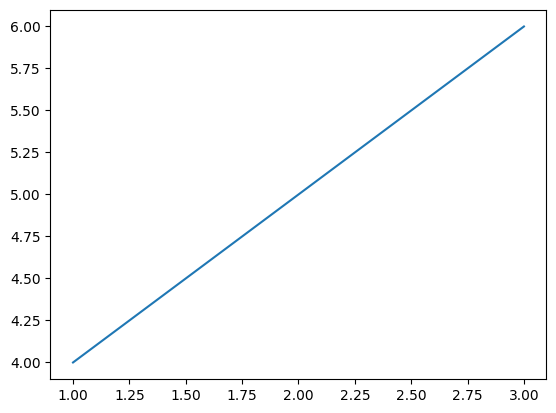

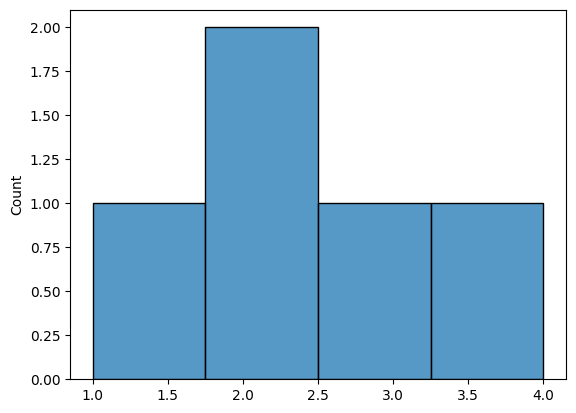

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Простой график
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

# Гистограмма
sns.histplot([1, 2, 2, 3, 4])
plt.show()